In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# 安装 mmengine 和 mmcv 依赖
# 为了防止后续版本变更导致的代码无法运行，我们暂时锁死版本
!pwd
%pip install -U "openmim==0.3.7"
!mim install "mmengine==0.7.1"
!mim install "mmcv==2.0.0"

!pip install opencv-python pillow matplotlib seaborn tqdm pytorch-lightning 'mmdet>=3.0.0rc1'
# 从 github 上下载最新的 mmsegmentation 源代码
!git clone https://github.com/open-mmlab/mmsegmentation.git -b dev-1.x
# 进入主目录
import os
os.chdir('mmsegmentation')


!pip install -v -e .

In [ ]:
from mmengine.utils import get_git_hash
from mmengine.utils.dl_utils import collect_env as collect_base_env

import mmseg

# 环境信息收集和打印
def collect_env():
    """Collect the information of the running environments."""
    env_info = collect_base_env()
    env_info['mmseg'] = f'{mmseg.__version__}+{get_git_hash()[:7]}'
    return env_info


if __name__ == '__main__':
    for name, val in collect_env().items():
        print(f'{name}: {val}')

# 1 数据集准备和可视化



In [5]:

import os

# 创建 checkpoint 文件夹，用于存放预训练模型权重文件
os.mkdir('checkpoint')

# 创建 outputs 文件夹，用于存放预测结果
os.mkdir('outputs')

# 创建 data 文件夹，用于存放图片和视频素材
os.mkdir('data')



In [ ]:
%cd ./data
! wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/watermelon/Watermelon87_Semantic_Seg_Labelme.zip
! wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/watermelon/Watermelon87_Semantic_Seg_Mask.zip
! unzip Watermelon87_Semantic_Seg_Labelme.zip
! unzip Watermelon87_Semantic_Seg_Mask.zip

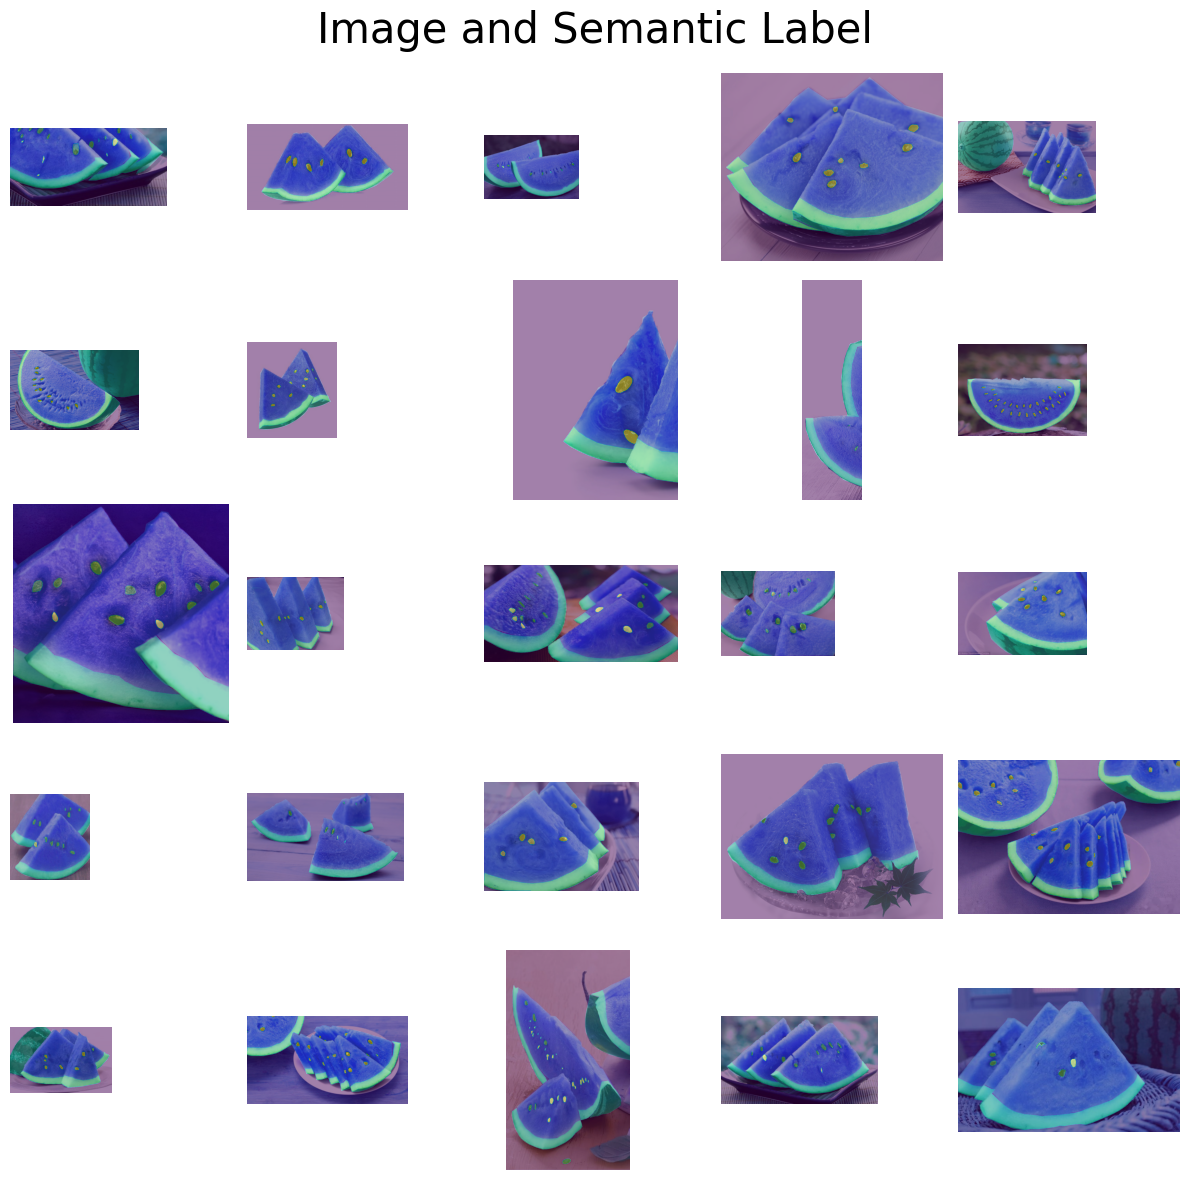

In [7]:
import os

import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# 指定图像和标注路径
PATH_IMAGE = 'Watermelon87_Semantic_Seg_Mask/img_dir/train'
PATH_MASKS = 'Watermelon87_Semantic_Seg_Mask/ann_dir/train'
# n行n列可视化
n = 5

# 标注区域透明度
opacity = 0.5

fig, axes = plt.subplots(nrows=n, ncols=n, sharex=True, figsize=(12,12))

for i, file_name in enumerate(os.listdir(PATH_IMAGE)[:n**2]):

    # 载入图像和标注
    img_path = os.path.join(PATH_IMAGE, file_name)
    mask_path = os.path.join(PATH_MASKS, file_name.split('.')[0]+'.png')
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    # 可视化
    axes[i//n, i%n].imshow(img)
    axes[i//n, i%n].imshow(mask[:,:,0], alpha=opacity)
    axes[i//n, i%n].axis('off') # 关闭坐标轴显示
fig.suptitle('Image and Semantic Label', fontsize=30)
plt.tight_layout()
plt.show()

# 2 自定义配置文件


In [8]:
%cd /content/mmsegmentation/

/content/mmsegmentation


In [9]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/DubaiDataset.py -P mmseg/datasets

!rm -rf mmseg/datasets/__init__.py # 删除原有文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/__init__.py -P mmseg/datasets

!rm -rf configs/_base_/datasets/DubaiDataset_pipeline.py
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/DubaiDataset_pipeline.py -P configs/_base_/datasets

!rm -rf configs/pspnet/pspnet_r50-d8_4xb2-40k_DubaiDataset.py # 删除原有文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/pspnet_r50-d8_4xb2-40k_DubaiDataset.py -P configs/pspn

--2023-06-14 00:59:44--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/DubaiDataset.py
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 867 [binary/octet-stream]
Saving to: ‘mmseg/datasets/DubaiDataset.py’

DubaiDataset.py     100%[===================>]     867  --.-KB/s    in 0.003s  

2023-06-14 00:59:46 (338 KB/s) - ‘mmseg/datasets/DubaiDataset.py’ saved [867/867]

--2023-06-14 00:59:46--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/__init__.py
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.o

In [10]:
from mmengine import Config
cfg = Config.fromfile('./configs/pspn/pspnet_r50-d8_4xb2-40k_DubaiDataset.py')

cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head

# 模型 decode/auxiliary 输出头，指定为类别个数
cfg.model.decode_head.num_classes = 6
cfg.model.auxiliary_head.num_classes = 6

cfg.train_dataloader.batch_size = 8

cfg.test_dataloader = cfg.val_dataloader

# 结果保存目录
cfg.work_dir = './work_dirs/DubaiDataset'

# 训练迭代次数
cfg.train_cfg.max_iters = 3000
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 1500

# 随机数种子
cfg['randomness'] = dict(seed=0)
# cfg.data_root = '/content/mmsegmentation/data/Watermelon87_Semantic_Seg_Mask'

print(cfg.pretty_text)

cfg.dump('pspnet-DubaiDataset_20230612.py')

norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(64, 64))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(256, 256)),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=51

# 3 模型训练

在验证数据流本身没有问题后，就可以开始进行训练了

In [12]:
import numpy as np

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine
from mmengine import Config
cfg = Config.fromfile('pspnet-DubaiDataset_20230612.py')
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)
runner.train()

06/14 01:06:16 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_

/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ig

06/14 01:06:17 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/14 01:06:17 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


06/14 01:06:19 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


06/14 01:06:20 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
06/14 01:06:20 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
06/14 01:06:20 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

06/14 01:06:20 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
06/14 01:06:20 - mmengine - INFO - Checkpoints will be saved to /content/mmsegmentation/work_dirs/DubaiDataset.
06/14 01:06:23 - mmengine - INFO - Exp name: pspnet-DubaiDataset_20230612_20230614_010616
06/14 01:07:15 - mmengine - INFO - Iter(train) [ 100/3000]  lr: 9.9779e-03  eta: 0:26:29  time: 0.5492  data_time: 0.0176  memory: 11478  loss: 0.0735  decode.loss_ce: 0.0512  decode.acc_seg: 77.5635  aux.loss_ce: 0.0223  aux.acc_seg: 80.9906
06/14 01:08:10 - mmengine - INFO - Iter(trai

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


06/14 01:11:04 - mmengine - INFO - per class results:
06/14 01:11:04 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|     bk     | 61.86 | 99.55 |
|    red     | 12.65 | 12.74 |
|   green    |  4.01 |  4.11 |
|   white    | 12.25 | 12.28 |
| seed-black | 44.43 | 58.23 |
| seed-white |  0.0  |  0.0  |
+------------+-------+-------+
06/14 01:11:04 - mmengine - INFO - Iter(val) [11/11]  aAcc: 63.5400  mIoU: 22.5300  mAcc: 31.1500  data_time: 0.0035  time: 4.9814
06/14 01:12:03 - mmengine - INFO - Iter(train) [ 500/3000]  lr: 9.8888e-03  eta: 0:23:45  time: 0.5994  data_time: 0.0266  memory: 10438  loss: 0.0491  decode.loss_ce: 0.0346  decode.acc_seg: 76.1261  aux.loss_ce: 0.0145  aux.acc_seg: 79.8584
06/14 01:13:01 - mmengine - INFO - Iter(train) [ 600/3000]  lr: 9.8665e-03  eta: 0:22:52  time: 0.5795  data_time: 0.0176  memory: 3970  loss: 0.0532  decode.loss_ce: 0.0379  decode.acc_seg: 78.2562  aux.loss_ce: 0.0153  aux.a

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

##4 训练日志可视化



In [27]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
# !rm -rf /home/featurize/.cache/matplotlib

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font",family='SimHei') # 中文字体

--2023-06-14 01:48:45--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050868 (9.6M) [application/x-font-ttf]
Saving to: ‘/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’

/usr/local/lib/pyth 100%[===================>]   9.58M  4.41MB/s    in 2.2s    

2023-06-14 01:48:49 (4.41 MB/s) - ‘/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’ saved [10050868/10050868]



In [30]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
log_path = '/content/mmsegmentation/work_dirs/DubaiDataset/20230614_010357/vis_data/scalars.json'
with open(log_path, "r") as f:
  json_list = f.readlines()
len(json_list)
eval(json_list[4])


{'aAcc': 63.54,
 'mIoU': 22.53,
 'mAcc': 31.15,
 'data_time': 0.00350041389465332,
 'time': 4.981427311897278,
 'step': 400}

In [ ]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for each in json_list[:-1]:
  if 'aAcc' in each:
    df_test = df_test.append(eval(each), ignore_index=True)
  else:
    df_train = df_train.append(eval(each), ignore_index=True)

In [ ]:
df_train

In [34]:
df_test

,aAcc,mIoU,mAcc,data_time,time,step
0,63.54,22.53,31.15,0.003500,4.981427,400.0
1,75.85,39.89,47.21,0.003766,0.450465,800.0
2,73.33,34.06,40.07,0.002512,0.450411,1200.0
3,72.27,36.70,43.99,0.005160,0.455898,1600.0
4,67.68,29.24,35.58,0.002483,0.458458,2000.0
5,79.99,42.53,48.52,0.004081,0.447354,2400.0
6,82.98,51.16,59.12,0.002455,0.467228,2800.0


In [35]:
df_train.to_csv('/content/mmsegmentation/work_dirs/DubaiDataset/20230614_010357/vis_data/train_log-train_data.csv', index=False)
df_test.to_csv('/content/mmsegmentation/work_dirs/DubaiDataset/20230614_010357/vis_data/train_log-test_data.csv', index=False)

In [37]:
from matplotlib import colors as mcolors
import random
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']

def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

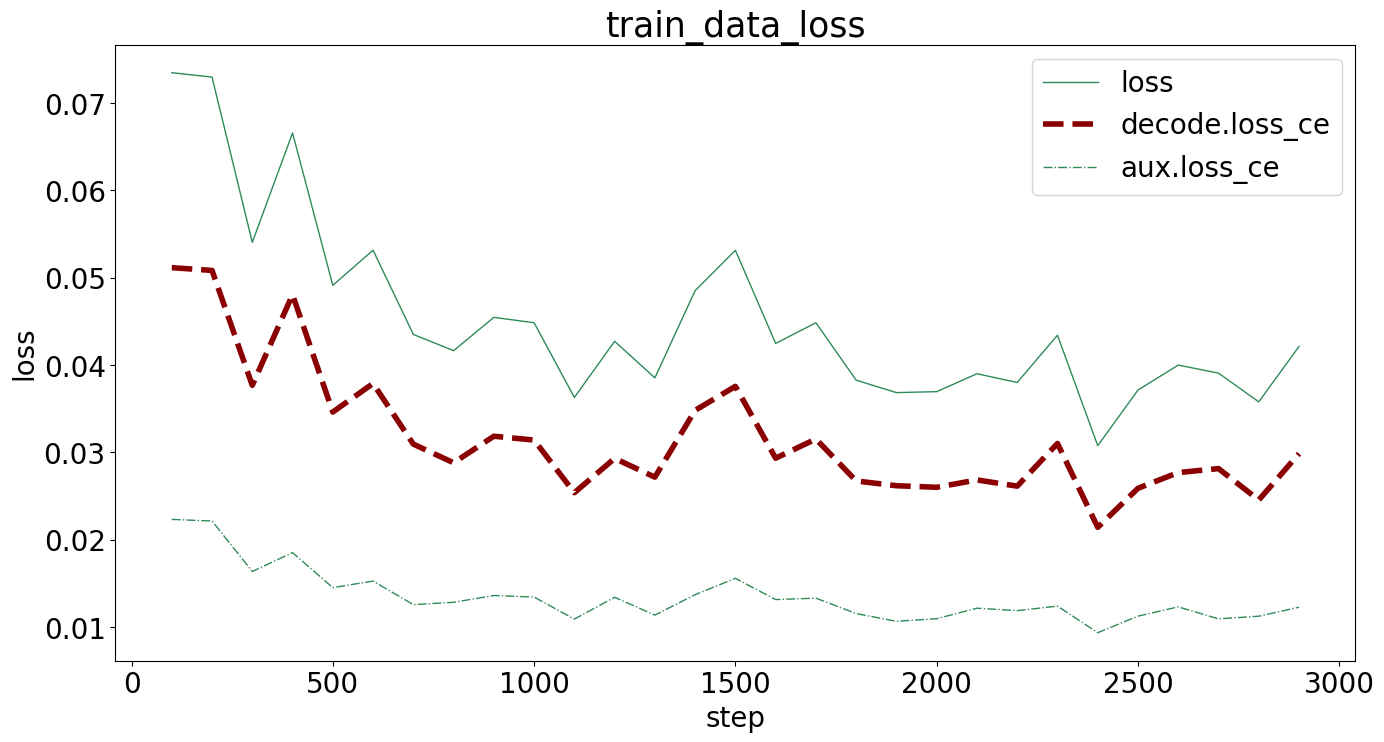

In [38]:
metrics = ['loss', 'decode.loss_ce', 'aux.loss_ce']
plt.figure(figsize=(16, 8))

x = df_train['step']
for y in metrics:
    plt.plot(x, df_train[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('train_data_loss', fontsize=25)
# plt.savefig('训练集损失函数.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()

**训练集准确率**

In [39]:
df_train.columns

Index(['lr', 'data_time', 'loss', 'decode.loss_ce', 'decode.acc_seg',
       'aux.loss_ce', 'aux.acc_seg', 'time', 'memory', 'step'],
      dtype='object')

In [ ]:
metrics = ['decode.acc_seg', 'aux.acc_seg']

In [ ]:
plt.figure(figsize=(16, 8))

x = df_train['step']
for y in metrics:
    plt.plot(x, df_train[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('train_data_acc', fontsize=25)
# plt.savefig('训练集准确率.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()

**测试集评估指标**

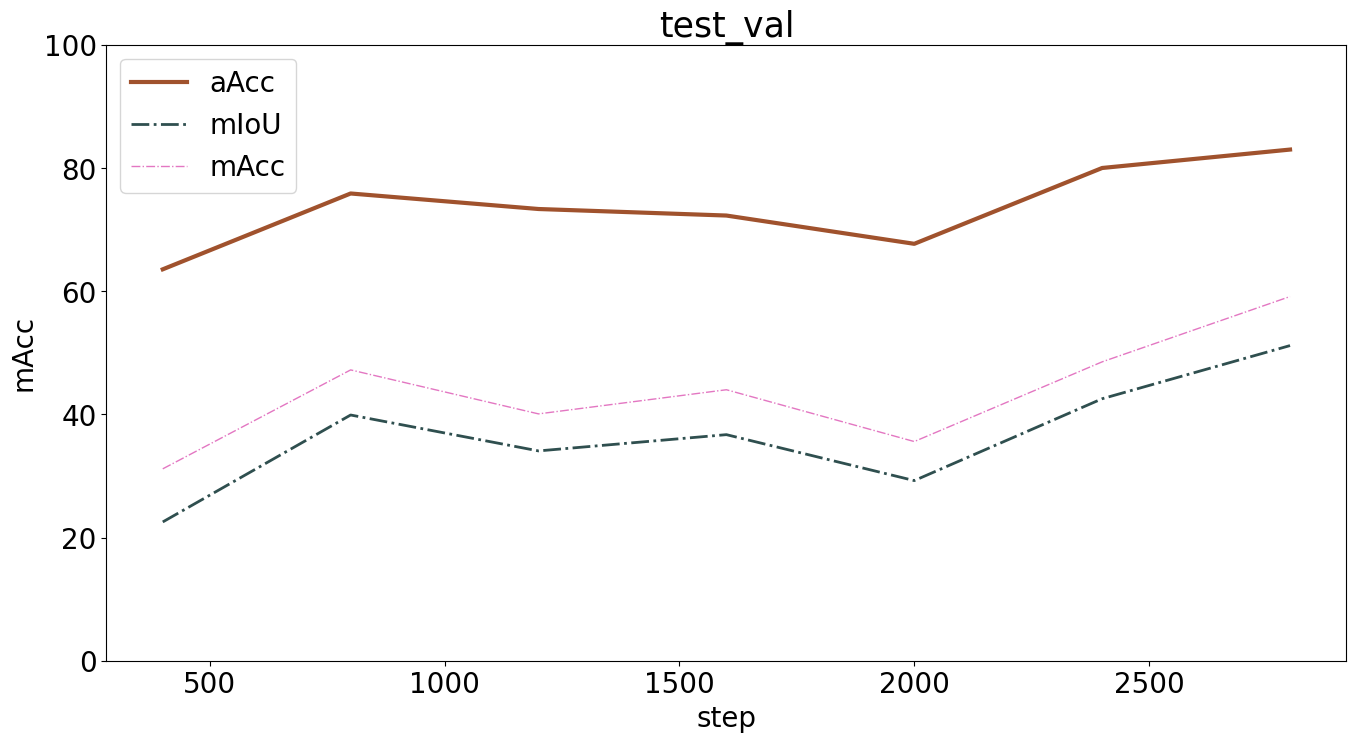

In [42]:
df_test.columns
metrics = ['aAcc', 'mIoU', 'mAcc']
plt.figure(figsize=(16, 8))

x = df_test['step']
for y in metrics:
    plt.plot(x, df_test[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.ylim([0, 100])
plt.xlabel('step', fontsize=20)
plt.ylabel(y, fontsize=20)
plt.title('test_val', fontsize=25)
# plt.savefig('测试集分类评估指标.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()

# 5 模型预测



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import cv2

# 载入 config 配置文件
from mmengine import Config
cfg = Config.fromfile('pspnet-DubaiDataset_20230612.py')

from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner

register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

In [44]:
checkpoint_path = './work_dirs/DubaiDataset/iter_3000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: ./work_dirs/DubaiDataset/iter_3000.pth


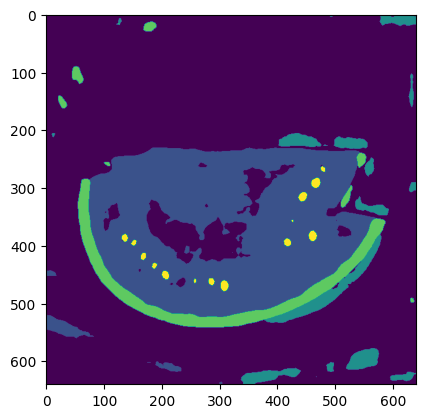

In [50]:
img = mmcv.imread('/content/mmsegmentation/data/Watermelon87_Semantic_Seg_Mask/img_dir/val/L007-05_5.jpg')
result = inference_model(model, img)
result.keys()
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()
pred_mask.shape
np.unique(pred_mask)
plt.imshow(pred_mask)
plt.show()

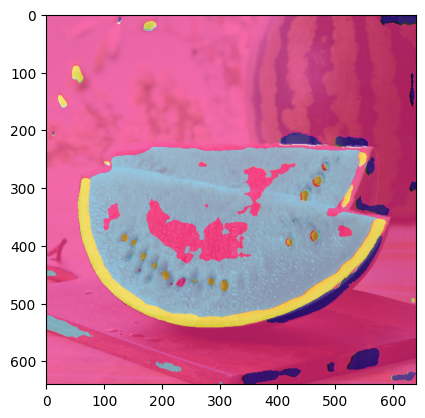

In [51]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.7, out_file='pred.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

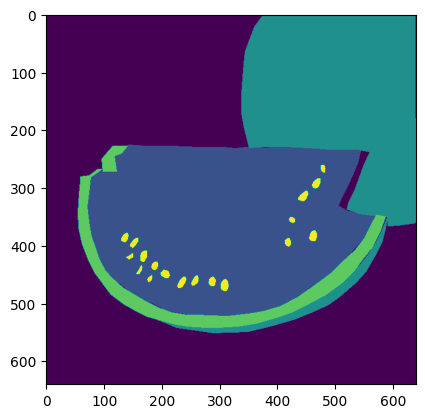

In [52]:
label = mmcv.imread('/content/mmsegmentation/data/Watermelon87_Semantic_Seg_Mask/ann_dir/val/L007-05_5.png')
label.shape
label_mask = label[:,:,0]
label_mask.shape
np.unique(label_mask)

plt.imshow(label_mask)
plt.show()


**对比测试集标注和语义分割结果**

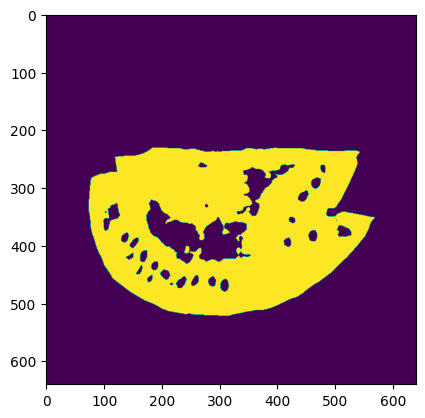

In [53]:
TP = (label_mask == 1) & (pred_mask==1)
# 真实为背景，预测为背景
TN = (label_mask == 0) & (pred_mask==0)
# 真实为前景，预测为背景
FN = (label_mask == 1) & (pred_mask==0)
# 真实为背景，预测为前景
FP = (label_mask == 0) & (pred_mask==1)
plt.imshow(TP)
plt.show()

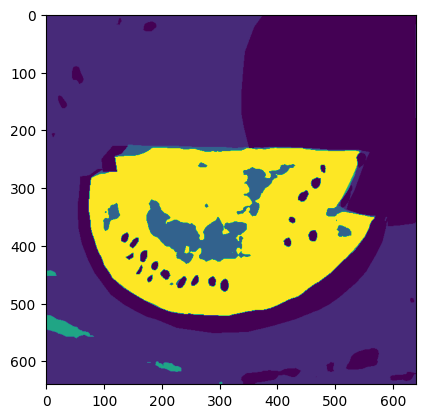

In [54]:
confusion_map = TP * 255 + FP * 150 + FN * 80 + TN * 30
plt.imshow(confusion_map)
plt.show()

**混淆矩阵**

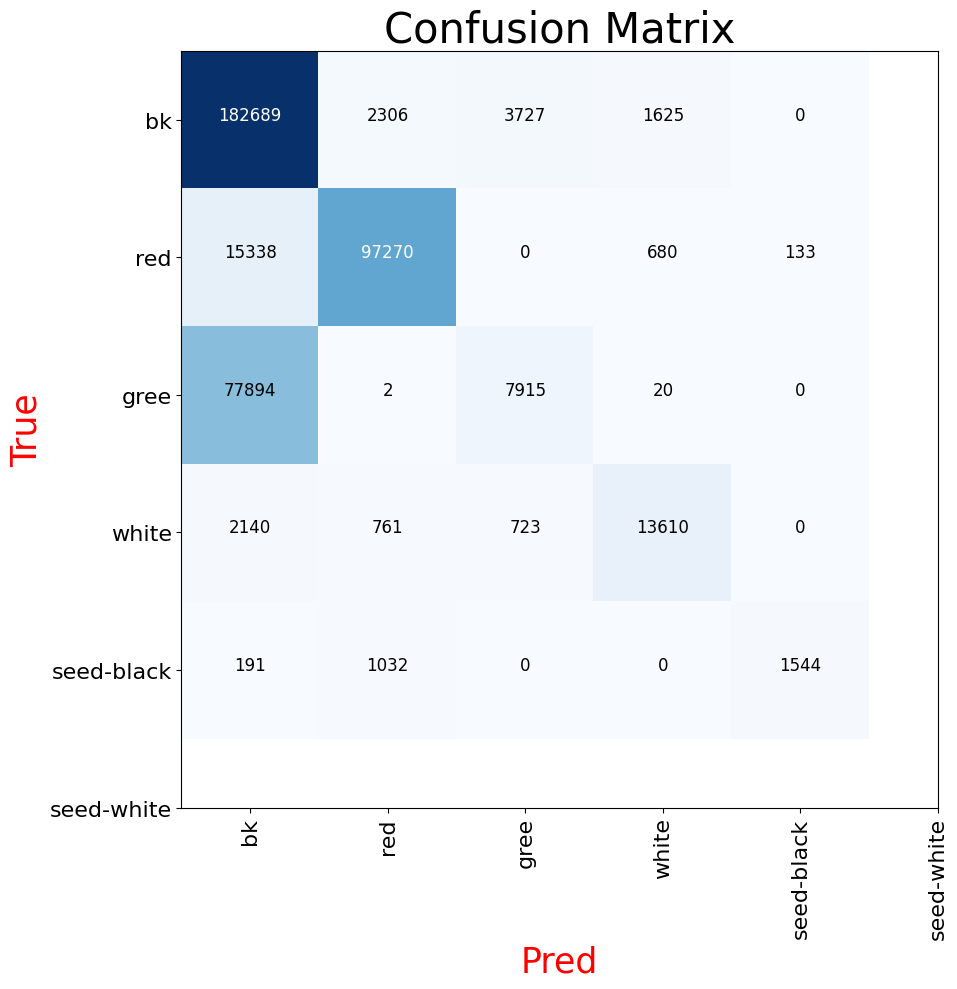

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix_model = confusion_matrix(label_mask.flatten(), pred_mask.flatten())
confusion_matrix_model
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))

    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)

    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

classes = ['bk', 'red', 'gree', 'white', 'seed-black', 'seed-white']
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

# 6 测试集性能评估


In [56]:
!python tools/test.py pspnet-DubaiDataset_20230612.py work_dirs/DubaiDataset/iter_3000.pth

06/14 02:22:17 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_

**速度指标 FPS**

In [ ]:
!python tools/analysis_tools/benchmark.py pspnet-DubaiDataset_20230612.py work_dirs/DubaiDataset/iter_3000.pth